# Machine Learning opdracht 3

**namen:** Ruben de Winter, Tristan Hendriks, Rik van der Meer, Vinay Gobardhan

# 1. Inleiding

In deze opdracht onderzoeken we hoe we met behulp van machine learning muziekgenres kunnen bepalen op basis van geluidsfragmenten. De dataset bestaat uit twee delen: een gelabelde set waarbij het genre bekend is, en een ongelabelde set waarbij dit niet het geval is.

Omdat de genres van de ongelabelde fragmenten niet bekend zijn, maken we gebruik van unsupervised learning. Dit betekent dat het model zelf groepen (clusters) probeert te vinden in de data, zonder vooraf labels te gebruiken.

Het doel van deze notebook is om:
	•	geluidsfragmenten om te zetten naar numerieke kenmerken,
	•	te bepalen hoeveel verschillende genres in de ongelabelde data voorkomen,
	•	clusters te koppelen aan echte muziekgenres,
	•	en uiteindelijk per fragment een genre te voorspellen.

### 1\.1 Inladen libraries

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (silhouette_score, davies_bouldin_score, classification_report, accuracy_score)
from sklearn.cluster import KMeans
from sklearn.cluster import  AgglomerativeClustering
from sklearn.cluster import DBSCAN

np.random.seed(42)

We gebruiken "random seed" zodat alles wat we moeten berekenen steeds hetzelfde resultaat zal geven\. 

## 1.2 Data

De opdracht maakt gebruik van de volgende bestanden en mappen:
•	labeled data/: Bevat geluidsfragmenten waarvan het genre bekend is.
•	labels_new.csv: Bevat per geluidsbestand het bijbehorende genre.
•	unlabeled data/: Bevat geluidsfragmenten waarvan het genre niet bekend is.
•	sample_submission.csv: Voorbeeld van het formaat waarin de voorspellingen moeten worden ingeleverd.

De gelabelde dataset gebruiken we uitsluitend om clusters te interpreteren, niet om het clusteringmodel te trainen.

<hr>

# 2\. Feature engineering

## 2.1 Waarom audiofeatures?

Machine learning modellen kunnen geen ruwe audio gebruiken. Daarom zetten we elk geluidsfragment om in een set numerieke kenmerken, zogenaamde audiofeatures. Deze kenmerken beschrijven eigenschappen zoals toonhoogte, energie en ritme.

Voor elk fragment gebruiken we de eerste 30 seconden audio en berekenen we per feature het gemiddelde over de tijd. Zo krijgt elk fragment één vaste featurevector.

## 2.2 Uitleg features

Librosa is een manier om muziek te analyseren\. Het haalt features uit de muziek om dingen uit de muziek te kunnen achterhalen\. Dit is erg belangrijk voor ons om goed de muziek te kunnen analyseren\. Hieronder leggen we uit wat elke feature inhoud die bij librosa passen\.

__Spectrale features:__ Zijn de eigenschappen waaruit de audio bestaat. Deze bevatten bijvoorbeeld informatie over de toon (hoog of laag), helderheid en variate van de audio. Door het uitvoeren van de Fourier transformatie is het mogelijk om deze verschillende spectral features te verkrijgen.



__Melspectogram:__ Laat zien hoe hard elke toon klink over tijd, maar aangepast naar de mel schaal zodat dit beter representeert hoe een mens het hoort. Dit doet de mel schaal door eerst de Fourier transform toe te passen en deze daarna om te zetten van 'hertz'--> 'mels'. 
De gebruikte formule is als volgt, hoge hertz worden hier harder gestraft. 

$$
m = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)
$$


Bron Formule: [Mel scale](https://grokipedia.com/page/Mel_scale)




__mfcc:__ mfcc zijn geluidsfeatures die kijken naar de timbre oftewel klankkleur van een geluidsfragment, hierbij wordt niet gekeken naar de toonhoogte van de audio (Geeksforgeeks, 2025). In onze opdracht hebben wij gekeken naar de eerste 5 coefficienten. Deze coefficienten zeggen elk iets over de audio. MFCC 1 omschrijft meer algemeen de timbre en elke mfcc 2 omschrijft de hoge vs lage frequentie verdeling en elke mfcc daarna zegt steeds iets specifiekers over de audio (Geeksforgeeks, 2025).

De mfcc wordt berekent door de zelfde stappen te doorlopen als bij het verkrijgen van het melspectogram waarna je Discrete Cosine Transform (DCT) uitvoert. 
stappen: Audio opdelen in kleinere stukken, tranformeren met Fourier, MEL filter berekenen en daarna DCT uitvoeren (Geeksforgeeks, 2025). 


__Root-Mean-Square (Energy):__  De RMS neemt het kwadraat van de audio (zodat negatieve waarden positief worden), hierna neemt hij het gemiddelde van de waardes en daarna neemt hij de wortel (Bos, 2013). DE RMS zegt hoe sterk een geluid voorkomt / hoe luid het is.



__Spectral centroid:__  De spectral centroid omschrijft de 'helderheid' van de audio, hoe groter het aandeel hoge frequenties hoe meer helder de audio is, het is een gewogen gemiddelde van de frequenties, waarbij de amplitudes bepalen hoeveel invloed elke frequentie heeft (Bos, 2013). verschillende instrumenten hebben vaak een verschillende helderheid, met de spectral centroid kan een algoritme deze onderscheiden.
$$
\text{Centroid} = \frac{\sum_{n=0}^{N-1} f(n) \cdot x(n)}{\sum_{n=0}^{N-1} x(n)}
$$

Bron formule: [Spectral centroid](https://studenttheses.uu.nl/bitstream/handle/20.500.12932/15175/scriptie.pdf?sequence=2)



__Spectral bandwidth:__ Geeft weer hoe verspreid  de energie is rondom de centroid. Een hogere bandwidth wilt betekenen dat er een grotere variatie aan frequenties aanwezig zijn. Je kunt het zien als een soortvan standaard deviatie van de energie. Deze wordt opnieuw ook gewogen met de amplitude. 
$$
\text{Spectral Bandwidth} = \left( \sum_{k} S[k, t] \cdot (f[k, t] - \text{centroid}[t])^p \right)^{1/p}
$$



Bron formule: [librosa.feature.spectral_bandwidth.](https://librosa.org/doc/main/generated/librosa.feature.spectral_bandwidth.html)

__Spectral rolloff:__ Is de frequentie in je data waarbij 85% van de energie onder het snijpunt valt, dit is een gewogen gemiddelde van amplitude en frequentie wat betekend dat frequenties met lage amplitude minder meetellen voor deze waarde (Bos, 2013). Als de rolloff hoog is kun je constateren dat er veel hoge frequenties in de audio voorkomen, ook kun je stellen dat het grootste gedeelte van je audio onder deze frequentie zit.




__Zero-Crossings_rate:__ De Zero-Crossing_rate is een maat voor de hoeveelheid ruis die in een audiofragment zit, deze maat word bepaald door de hoeveelheid keren dat de geluidsgolf door de x-as kruist per tijdeenheid in percentage (Bos, 2013; Librosa development team, z.d.-B).




__Tempo:__ Toont het tempo van de audio, oftewel de beats per minute (librosa development team, z.d.-C).



In [2]:
!rm -f /work/*.wav



'rm' is not recognized as an internal or external command,
operable program or batch file.


## 2.3 Functies maken voor feature extraction

In [3]:
def extract_audio_features(
    file_path: str,
    duration: float = 30.0,
    sr: int = 22050,
    n_mfcc: int = 5,
) -> Dict[str, float]:
    signal, sampling_rate = librosa.load(file_path, sr=sr, duration=duration)

    features: Dict[str, float] = {}
    features["spectral_centroid"] = float(
        np.mean(librosa.feature.spectral_centroid(y=signal, sr=sampling_rate))
    )
    features["spectral_bandwidth"] = float(
        np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=sampling_rate))
    )
    features["spectral_rolloff"] = float(
        np.mean(librosa.feature.spectral_rolloff(y=signal, sr=sampling_rate))
    )
    features["zero_crossing_rate"] = float(
        np.mean(librosa.feature.zero_crossing_rate(signal))
    )
    features["rms"] = float(np.mean(librosa.feature.rms(y=signal)))

    tempo = librosa.beat.tempo(y=signal, sr=sampling_rate)[0]
    features["tempo"] = float(tempo)

    mfcc_values = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        features[f"mfcc_{i + 1}"] = float(np.mean(mfcc_values[i]))

    return features


def build_feature_dataframe(
    folder: str,
    filenames: List[str],
    duration: float = 30.0,
) -> pd.DataFrame:
    rows = []
    for fn in filenames:
        path = os.path.join(folder, fn)
        feats = extract_audio_features(path, duration=duration)
        feats["filename"] = fn
        rows.append(feats)

    return pd.DataFrame(rows)



## 2.4 Inladen van de data

In [4]:
labels_df = pd.read_csv("labels_new.csv")

labeled_folder = "labeled data"
unlabeled_folder = "unlabeled data"

labeled_filenames = labels_df["filename"].tolist()
unlabeled_filenames = sorted(os.listdir(unlabeled_folder))

df_labeled = build_feature_dataframe(labeled_folder, labeled_filenames)
df_labeled = df_labeled.merge(labels_df, on="filename", how="left")

df_unlabeled = build_feature_dataframe(unlabeled_folder, unlabeled_filenames)

df_labeled.head()




c:\Users\User\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\User\AppData\Local\Temp\ipykernel_37840\3949852808.py:24: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=signal, sr=sampling_rate)[0]
C:\Users\User\AppData\Local\Temp\ipykernel_37840\3949852808.py:24: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=signal, sr=sampling_rate)[0]


,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms,tempo,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,filename,genre
0,2656.165734,2337.227557,5325.867795,0.158776,0.113753,107.666016,-75.517509,81.911423,-22.081081,69.876999,-11.740438,m00248.wav,metal
1,3760.424487,3053.066772,7442.646662,0.212375,0.096312,123.046875,-89.736382,36.286201,11.469535,37.495590,9.199136,m00230.wav,country
2,2290.107317,2181.589027,4819.512524,0.113229,0.102282,107.666016,-122.780525,95.061287,-29.363251,46.780041,-15.998561,m00637.wav,hiphop
3,2378.392048,2092.439557,4748.562953,0.141317,0.131590,123.046875,-57.683388,101.432320,-41.485245,55.130600,-23.349279,m00627.wav,metal
4,1995.600514,2295.466240,4557.697440,0.070323,0.078412,123.046875,-198.632797,102.413582,-10.031449,30.802383,-3.310606,m00138.wav,reggae


# 3. Exploratory Data Analysis (EDA)

We bekijken de data globaal om inzicht te krijgen in verdelingen, uitschieters en relaties tussen features.

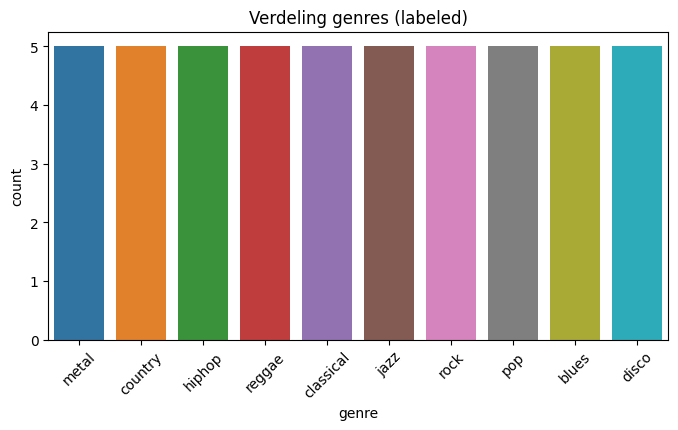

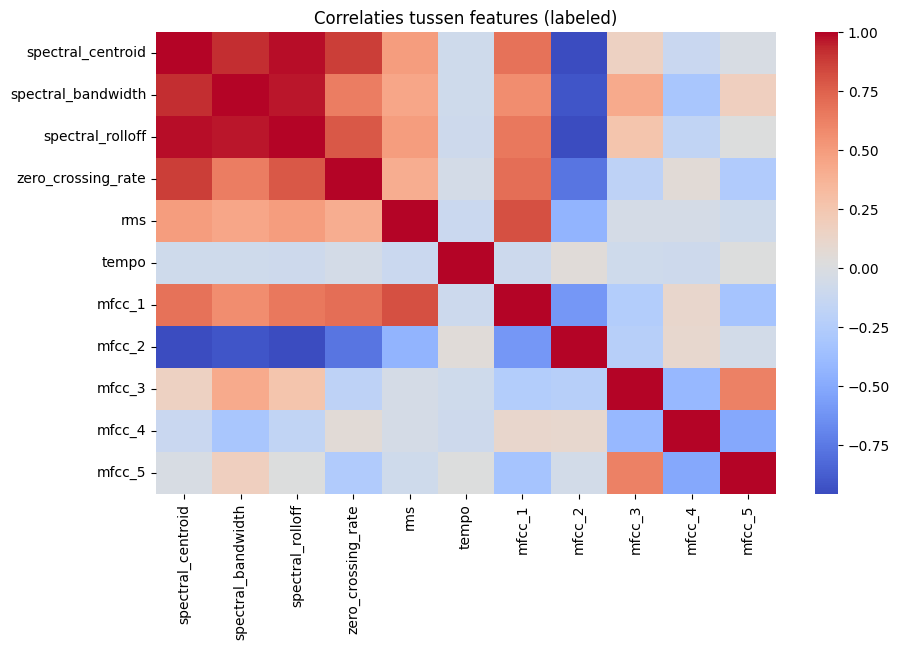

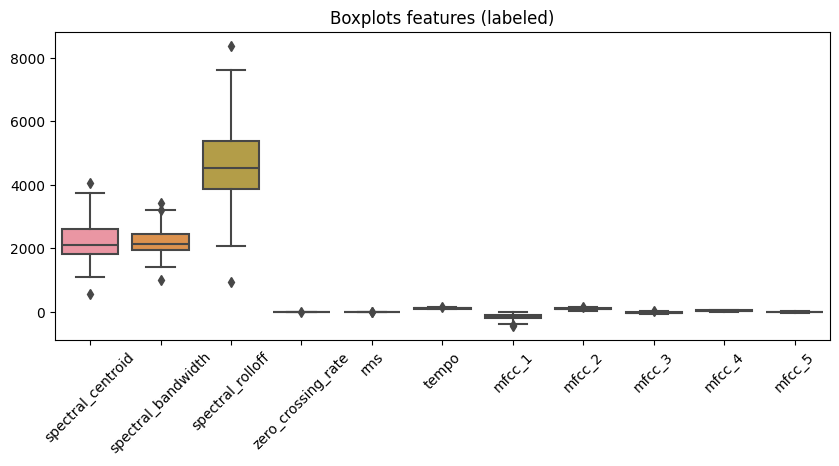

In [5]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_labeled, x="genre")
plt.xticks(rotation=45)
plt.title("Verdeling genres (labeled)")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_labeled.drop(columns=["filename", "genre"]).corr(), cmap="coolwarm")
plt.title("Correlaties tussen features (labeled)")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=df_labeled.drop(columns=["filename", "genre"]))
plt.xticks(rotation=45)
plt.title("Boxplots features (labeled)")
plt.show()

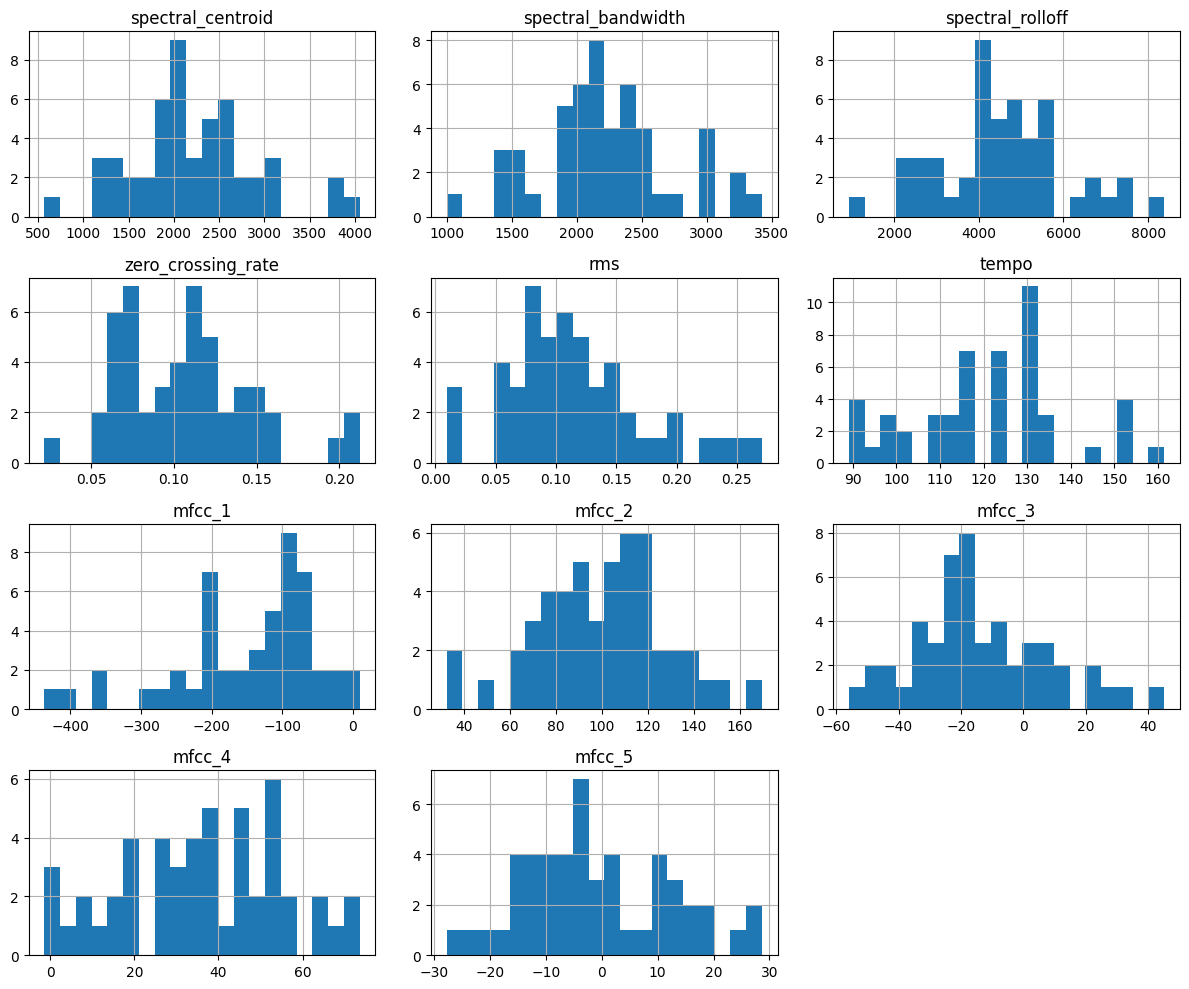

In [6]:
df_labeled.drop(columns="genre").hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

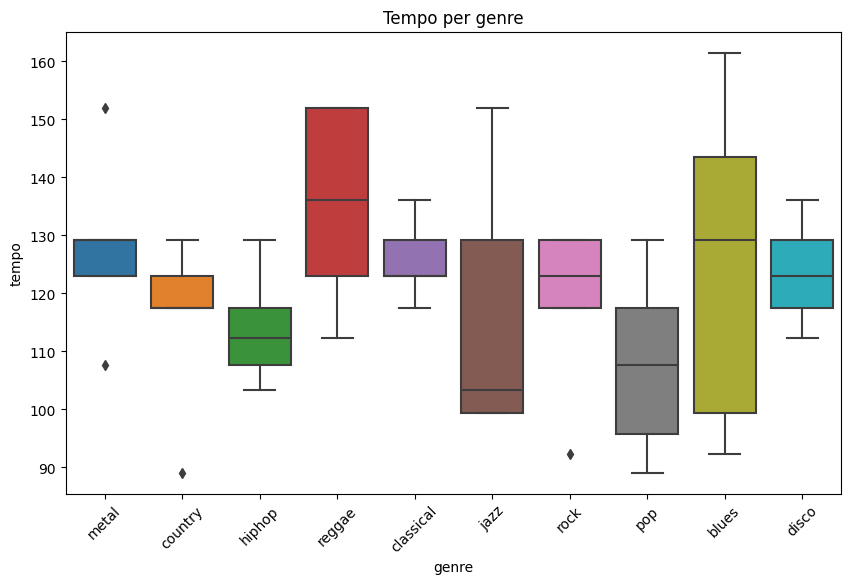

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_labeled, x="genre", y="tempo")
plt.xticks(rotation=45)
plt.title("Tempo per genre")
plt.show()


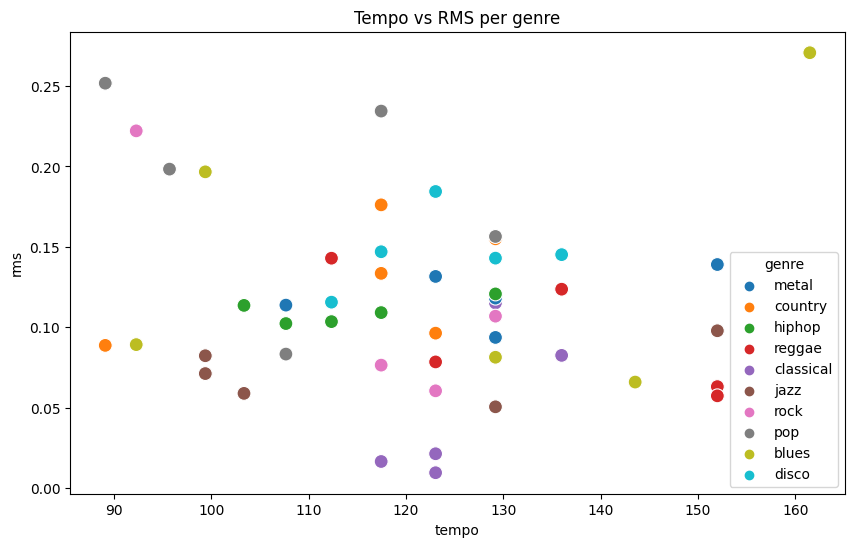

In [8]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_labeled, x="tempo", y="rms", hue="genre", palette="tab10", s=100)
plt.title("Tempo vs RMS per genre")
plt.show()


# 4\. Schalen van de data

Omdat de features verschillende schalen hebben, standaardiseren we de data met StandardScaler\.

In [9]:
feature_cols = [c for c in df_labeled.columns if c not in ["filename", "genre"]]

scaler = StandardScaler()
X_labeled = scaler.fit_transform(df_labeled[feature_cols])
X_unlabeled = scaler.transform(df_unlabeled[feature_cols])

# 5. Bepalen van aantal clusters

## 5\.1 Elleboog methode \(Inertia\)

Hieronder voeren wij de elleboog methode uit\. De elleboog methode is een methode om perfect het juist aantal clusters te kunnen bepalen bij de clustermodellen die wij later uit moeten voeren\.  Je kijkt naar de afstand van de punten tot hun centrum en de verandering\. Op het moment dat je een buiging ziet \(de elleboog\) is dat een perfect juist aantal clusters\.

In [ ]:
k_values = range(2, 11)
inertias = []


for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_unlabeled)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(list(k_values), inertias, marker="o")
plt.xlabel("Aantal clusters (k)")
plt.ylabel("Inertia")
plt.title("Elleboogmethode (Inertia) voor K-Means")
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

## 5.2 Silhouette score

De elleboog is soms lastig “met het oog” te bepalen. Daarom gebruiken we ook de silhouette score. Die meet hoe goed de clusters van elkaar gescheiden zijn.
•	Hoger = beter (punten zitten dan dichter bij hun eigen cluster dan bij andere clusters).

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_unlabeled)
    sil_scores.append(silhouette_score(X_unlabeled, labels))

plt.figure(figsize=(10, 4))
plt.plot(list(k_values), sil_scores, marker="o")
plt.xlabel("Aantal clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score per k")
plt.show()

k_silhouette = int(list(k_values)[int(np.argmax(sil_scores))])
print("Beste k volgens silhouette:", k_silhouette)

## 5.3 Hoe goed kunnen we clusters koppelen aan genres?

Omdat het doel van deze opdracht is om genres te vinden, doen we ook een praktische check:
we clusteren (met Agglomerative) en kijken hoe goed we clusters kunnen vertalen naar genres met de gelabelde data (majority vote).

In [ ]:
def build_cluster_to_genre_map(cluster_labels, genres):
    df_map = pd.DataFrame({"cluster": cluster_labels, "genre": genres})
    return (
        df_map.groupby("cluster")["genre"]
        .agg(lambda x: x.value_counts().idxmax())
        .to_dict()
    )

def apply_cluster_to_genre(cluster_labels, mapping):
    return np.array([mapping.get(int(c), "unknown") for c in cluster_labels], dtype=object)

scores_k = []

X_combined = np.vstack([X_labeled, X_unlabeled])

for k in range(2, 11):
    model = AgglomerativeClustering(n_clusters=k)
    combined_clusters = model.fit_predict(X_combined)

    labeled_clusters = combined_clusters[:len(X_labeled)]
    mapping = build_cluster_to_genre_map(labeled_clusters, df_labeled["genre"])

    y_true = df_labeled["genre"].to_numpy()
    y_pred = apply_cluster_to_genre(labeled_clusters, mapping)

    acc = accuracy_score(y_true, y_pred)
    scores_k.append({"k": k, "mapping_accuracy_labeled": acc})

mapping_table = pd.DataFrame(scores_k).sort_values("mapping_accuracy_labeled", ascending=False)
mapping_table

In [ ]:
k_final = 7 
print("Definitief gekozen k_final =", k_final)

In [ ]:
df_unlabeled

# Hoofdstuk 7 = “Unsupervised learning: 3 algoritmes”

# 7.1 Unsupervised learning

## 7.1 KMeans

KMeans is een clustering model die volgens zijn naam een K-aantal clusters maakt. Het doel van het model is a.o. om te vinden hoeveel clusters er bestaan in je data, dit is dus nuttig voor onze opdracht aangezien wij niet weten hoeveel genres er zijn in de unlabeled data.

Om erachter te komen wat het optimale aantal clusters is voor het KMeans model kunnen we de elleboog methode toepassen. Hieronder voeren we die uit in combinatie met de Silhouette score en Kneed. Een reden voor het toepassen van deze methode is dat we het model niet te complex willen maken en meer clusters aanmaken dan in de realiteit voorkomt (Geelen, 2023). De elleboog methode kan overfitting voorkomen.

__inertia:__ Inertia is de hoeveelheid fout (sum) dat de datapunten van elk cluster hebben, dit wordt standaard berekent met de 'euclidean distance'(Scikit-learn, z.d.). Hierbij wordt echter niet echt rekening gehouden met het duidelijk gescheid houden van elk cluster. Een laag inertia betekend weinig spreiding --> goed

__Silhouette:__ De silhouette score meet hoe goed de datapunten passen binnen hun clusters, vergeleken met andere clusters (Geelen, 2023). Hiermee vergelijkt het met de 'euclidean distance' de gemiddelde afstand van een cluster van zichzelf (de spreiding eigenlijk) met de gemiddelde afstand van het cluster naar een ander cluster (Geelen, 2023). Waar silhouette verschilt met __inertia__ is dat ook kijkt naar de kwaliteit, wat wil zeggen dat de clusters ook een duidelijke distinctie/afstand moeten hebben van elkaar. De silhouette score standaardiseert de uitkomst tussen -1 en 1, waarbij 1 een hoge score is met duidelijke clusters die goed gescheiden zijn (Geelen, 2023).


Bron Silhoutte formule (voor individuele datapunten):[Scikit-learn. (z.d.)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
a = afstand binnen cluster
b = afstand tot ander cluster
Max(a/b) = alleen hoogste getal word genomen in de breuk
$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

__Kneed:__ Kneed is een functie die goed samengaat met de elleboog methode. Een nadeel aan de elleboog methode kan zijn dat het niet duidelijk is waar precies de elleboog (het optimale cluster aantal) zit. Kneed kan de optimale elleboog vinden, maar werkt soms minder goed voor complexe curves(Geelen, 2023; Arvai, 2023). 

## 7.2 Vinden van optimaal aantal n_clusters met silhouette en kneed


In [ ]:
!pip install kneed==0.8.5

## 7.2.1 silhouette + kneed

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import matplotlib.pyplot as plt

# lijst met silhouette scores voor clusters 1-10
k_values = range(2, 11) 

silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_unlabeled)  
    score = silhouette_score(X_unlabeled, cluster_labels)
    silhouette_scores.append(score)


# vind optimale knee gebasseerd op silhouette score
kneedle = KneeLocator(k_values, silhouette_scores, curve='convex', direction='decreasing')
print(f'---------------------------------------------')
print("Optimale Knee gevonden door Kneed (optimale k):", kneedle.knee)

# plot silhouette score voor elke cluster hoeveelheid
plt.figure(figsize=(10,6))
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.axvline(kneedle.knee, color="red", linestyle="--", label=f"Kneedle Knee = {kneedle.knee}")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('grafiek 1.1: Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

# normalized knee point plot
kneedle.plot_knee_normalized(figsize=(10,6), title = 'grafiek 1.2: normalized knee point')



## 7.2.2 inertia + kneed

In [ ]:
# Lijst met inertia scores voor clusters 1-10
K = range(2, 11)

inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_unlabeled)
    inertia.append(kmeans.inertia_)

# kneed toepassen voor elleboog
kneedle = KneeLocator(K, inertia, curve="convex", direction="decreasing")
elbow_k = kneedle.elbow
print(f'---------------------------------------------')
print("Optimale Knee gevonden door Kneed (optimale k):", kneedle.knee)

# plot inertia voor elke clusterhoeveelheid
plt.plot(K, inertia, marker='o', label='Inertia')
plt.axvline(x=elbow_k, color='red', linestyle='--', label=f'Kneedle Knee = {kneedle.knee}')
plt.xlabel("Aantal clusters")
plt.ylabel("Inertia")
plt.title("grafiek 2.1 : Elleboog methode met Kneedle")
plt.legend()
plt.show()

# 
kneedle.plot_knee_normalized(figsize=(14,8), title = 'grafiek 2.2: normalized knee point')



## 7.2.3 optimale elleboog (knee)

- Grafiek 1.1 en 2.1 weergeven het optimale aantal clusters voor het model gekozen gebasseerd op  respectievelijk silhouette score en inertia. 
- Grafiek 2.1 en 2.2 weergeven het tradoff dillema op een duidelijke wijze, de rode lijn geeft weer wat als het ware het nut is van een extra cluster, de grafiek is genormalizeerd en het optimale cluster zit bij het punt waarbij deze het hoogste zit (Geelen, 2023).

In eerste instantie valt het op dat bij grafiek 1.1 5 clusters optimaal is en dat bij grafiek 2.1 3 clusters optimaal is. Grafiek 1.1 heeft waarschijnlijk meer clusters dan 2.1 aangezien meer clusters ervoor zorgen dat de afstanden tussen cluster kleiner wordt en afstand binnen clusters ook verkleint, wat belangrijk is voor de silhouette score. 

Ten tweede valt op te merken dat de toegevoegde waarde van een extra cluster voor grafiek 1.1 vrij snel daalt terwijl voor grafiek 2.1 de toegevoegde waarde bijna gelijk staat voor clusters 3-5.

Het doel voor onze opdracht is om te achterhalen welke genres voorkomen en deze juist te classificeren bij de audio bestanden. Hiermee is het belangrijk dat het model duidelijk onderscheid kan maken tussen deze genres. Muziek heeft best wel wat overlap en het juist classificeren kan daardoor moeilijk zijn. Wij vinden dat __de silhouette score de beste maat is__ voor het achterhalen van het optimale aantal clusters, aangezien het rekening houdt met het differentieren van de clusters en kijkt naar de kwaliteit hiervan. Daarbovenop is de afname in inertia voor 5 clusters ook niet zodanig groot dat het overfitting suggereerd. 

__Het optimale aantal clusters is daarom 5__ 








# 8 uploaden K-mean resultaten naar kaggle (30% acc)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)

df_unlabeled["cluster"] = kmeans.fit_predict(X_unlabeled)
display(df_unlabeled)


kmeans_labeled = KMeans(n_clusters=5, random_state=42)
df_labeled["cluster_kmean"] = kmeans_labeled.fit_predict(X_labeled)

# Bepaal per cluster het meest voorkomende genre
cluster_to_genre = (
    df_labeled
    .groupby("cluster_kmean")["genre"]
    .agg(lambda x: x.value_counts().idxmax())
)

print("Cluster → genre mapping:")
print(cluster_to_genre)

df_unlabeled["predicted_genre_KMeans"] = df_unlabeled["cluster"].map(cluster_to_genre)

display(df_unlabeled)

In [ ]:
# kaggle df
submit_df = df_unlabeled[["filename", "predicted_genre_KMeans"]].copy()

# Hernoem cluster kolom naar genre
submit_df.rename(columns={"predicted_genre_KMeans": "genre"}, inplace=True)

# delete spaties
submit_df["filename"] = submit_df["filename"].str.strip()
submit_df["genre"] = submit_df["genre"].str.strip()

# shape
display(submit_df.head())
print("Aantal rijen:", len(submit_df))
print("Kolommen:", submit_df.columns.tolist())

# csv download 
submit_df.to_csv("Cleaned_submission.csv", index=False, header = True)

print(submit_df.shape)   # moet (105, 2) zijn
print(submit_df.columns)



# Splitsen van de data

Hier  splitsen we de data ter voorbereiding van het modelleren

In [ ]:
X = X_labeled
y = df_labeled['genre']
# y = labeled_audio_features_df["genre"]
df_unlabeled_features = df_unlabeled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelleren Supervised modellen

## Ensemble modellen

Om te testen gebruiken we eerst ensemble modellen\. Dit zijn makkelijke modellen om te trainen\. Dit doen we om op basis van de ensemble modellen een goed beeld te kunnen krijgen, ook om te vergelijken met de clustering modellen die we later moeten gaan modelleren\.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Randomforestclassifier

param_grid = { 'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4] }

# cv, hyperparameter tuning
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

rf = RandomForestClassifier(random_state=42)

randomized_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

randomized_search.fit(X_train, y_train)

best_rf = randomized_search.best_estimator_

print("\nBeste hyperparameters:")
print(randomized_search.best_params_)

# Scores
y_pred_best = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_best)

print(f"Getunede RF test accuracy: {acc_rf:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_best))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Gradient boosting classifier 

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


param_grid_gb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0]
}

gb_base = GradientBoostingClassifier(random_state=42)

randomized_search_gb = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_grid_gb,
    n_iter=20,  # aantal random combinaties
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

randomized_search_gb.fit(X_train, y_train)

best_gb = randomized_search_gb.best_estimator_

print(randomized_search_gb.best_params_)

y_pred_best_gb = best_gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_best_gb)

print(f"Getunede Gradient Boosting accuracy: {acc_gb:.3f}")
print(classification_report(y_test, y_pred_best_gb))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Ada boosting classifier

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

param_grid_ab = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    "algorithm": ["SAMME", "SAMME.R"]
}

ab_base = AdaBoostClassifier(random_state=42)

randomized_search_ab = RandomizedSearchCV(
    estimator=ab_base,
    param_distributions=param_grid_ab,
    n_iter=20,   # aantal random combinaties
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

randomized_search_ab.fit(X_train, y_train)

best_ab = randomized_search_ab.best_estimator_

print("\nBeste hyperparameters AdaBoost:")
print(randomized_search_ab.best_params_)

print(
    f"Gemiddelde CV accuracy (train): "
    f"{randomized_search_ab.best_score_:.3f}"
)


y_pred_best_ab = best_ab.predict(X_test)
acc_ab = accuracy_score(y_test, y_pred_best_ab)

print(f"Getunede AdaBoost test accuracy: {acc_ab:.3f}")
print("\nClassification Report (getuned model):")
print(classification_report(y_test, y_pred_best_ab))


In [ ]:
acc_table = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting", "AdaBoost"],
    "Accuracy": [acc_rf, acc_gb, acc_ab]
}).sort_values(by="Accuracy", ascending=False)

acc_table

In [ ]:
best_model_name = acc_table.iloc[0]["Model"]
best_model = {"Random Forest": best_rf, "Gradient Boosting": best_gb, "AdaBoost": best_ab}[best_model_name]
df_unlabeled_features["predicted_genre"] = best_model.predict(X_unlabeled)
eindvoorspelling = df_unlabeled_features[["filename","predicted_genre"]]

# Clustering modellen

Hier beginnen we de clustering modellen te maken\.

# KMeans

In [ ]:
kmeans= KMeans(n_clusters=5,random_state=42)
kmeans_labels=kmeans.fit_predict(X_unlabeled)

df_unlabeled['kmeans_clusters']= kmeans_labels



nadere uitleg en conclusies staan in hoofdstuk 7

# AGGlomerative Clustering

Agglomerative Clustering is een hiërarchisch clustering-algoritme dat start met elke observatie als een apart cluster. Vervolgens worden in opeenvolgende stappen telkens de twee meest gelijkende clusters samengevoegd, totdat het gewenste aantal clusters is bereikt.

De overeenkomst tussen clusters wordt bepaald met een afstandmaat (bijvoorbeeld Euclidische afstand) en een linkage-criterium zoals single, complete of average linkage. Het resultaat is een hiërarchische structuur (dendrogram) waarin op verschillende niveaus clusters kunnen worden afgelezen.

Agglomerative Clustering is geschikt wanneer de structuur van de data onbekend is en wanneer een hiërarchische indeling gewenst is.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [ ]:
X_combined = np.vstack([X_labeled, X_unlabeled])
best_k = 5

agg = AgglomerativeClustering(n_clusters=best_k)
combined_labels = agg.fit_predict(X_combined)

# Split labels terug
df_labeled["agglo_cluster"] = combined_labels[:len(X_labeled)]
df_unlabeled["agglo_cluster"] = combined_labels[len(X_labeled):]


# Cluster → genre mapping

agg_cluster_to_genre = (
    df_labeled
    .groupby("agglo_cluster")["genre"]
    .agg(lambda x: x.value_counts().idxmax())
)

print("Agglomerative cluster → genre mapping:")
print(agg_cluster_to_genre)


# Genre voorspellen unlabeled


df_unlabeled["agglo_genre"] = (
    df_unlabeled["agglo_cluster"]
    .map(agg_cluster_to_genre)
)


agg_labels = agg.fit_predict(X_combined)


# DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is een clustering-algoritme dat groepen vormt op basis van puntdichtheid. DBSCAN kijkt naar waar veel datapunten liggen in plaats van het vooraf aangeven van de hoeveelheid clusters

Het algoritme gebruikt twee parameters:

ε (epsilon): de maximale afstand waarbinnen punten als buren worden gezien

min_samples: het minimum aantal punten binnen die afstand om een cluster te vormen

Punten in een dicht gebied vormen samen een cluster, terwijl punten die niet dicht genoeg bij andere punten liggen worden gezien als ruis (outliers). Hierdoor kan DBSCAN clusters van willekeurige vorm vinden en automatisch uitschieters detecteren.

DBSCAN is vooral geschikt wanneer het aantal clusters onbekend is en wanneer het belangrijk is om outliers te herkennen.

In [ ]:
dbscan= DBSCAN(eps=2, min_samples=3)
numeric_features = df_unlabeled_features.select_dtypes(include='number')
dbscan_labels= dbscan.fit_predict(numeric_features)
df_unlabeled_features['dbscan_clusters']= dbscan_labels

In [ ]:
# Resultaten
def cluster_and_score(name: str, model, X: np.ndarray) -> Tuple[str, float, np.ndarray]:
    labels = model.fit_predict(X)
    unique = set(labels)
    if len(unique) > 1 and not (len(unique) == 2 and -1 in unique):
        score = silhouette_score(X, labels)
    else:
        score = np.nan
    return name, score, labels


k_final = 5

results = []
results.append(cluster_and_score("KMeans", KMeans(n_clusters=k_final, random_state=42, n_init=10), X_unlabeled))
results.append(cluster_and_score("Agglomerative", AgglomerativeClustering(n_clusters=k_final), X_unlabeled))
results.append(cluster_and_score("DBSCAN", DBSCAN(eps=2.0, min_samples=3), X_unlabeled))

score_table = pd.DataFrame(
    [{"model": r[0], "silhouette": r[1]} for r in results]
).sort_values("silhouette", ascending=False)
score_table

# Visualisatie

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unlabeled)
agg_labels_subset = agg_labels[-len(X_unlabeled):]  # laatste n punten

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette="tab10", legend="full")
plt.title("KMeans clusters")

plt.subplot(1,3,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agg_labels_subset, palette="tab10", legend="full")
plt.title("Agglomerative Clusters")

plt.subplot(1,3,3)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dbscan_labels, palette="tab10", legend="full")
plt.title("DBSCAN clusters")

plt.show()


# Eindvoorspelling

In [ ]:
eindvoorspelling

# Hoofdstuk 8: Dimensional reduction (PCA & NMF)

## PCA

Hieronder zie je de code van PCA. Met een PCA kan je alle features die je hebt, verkorten tot een paar features. dit doet het op de volgende manieren

- Het kijkt naar combinaties van de features die de verschillen in de data laten zien
- Het visualiseren van de data wordt hierdoor makkelijker en zorgt ervoor dat de data overzichtelijker wordt

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unlabeled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=df_unlabeled_features["cluster"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA ")
plt.show()

## NMF

NMF is een manier om een samenvatting te kunnen maken van alle features. Dit doet het doormiddel van een matrix optespitsen in kleineren marticies

- Het gebruikt alles wat positief is

- Het maakt het gemakkelijk om de data te kunnen zien als basisfeatures. De data wordt veel overzichtelijker maar alle informatie blijft hetzelfde.

Functie:
$$
V≈W⋅H
$$
V = Alle kolommen/audiofeatures
W = hoe sterk elk basispatroon is
H = Wat de basispatronen zijn, Dit zijn de bouwstenen van muziek die herhaald worden in verschillende nummers

NMF breekt een muziekstuk op in niet-negatieve bouwstenen (instrumenten/geluidspatronen) en hun aanwezigheid in elk nummer. hiermee kan je genres herkennen

In [ ]:
nmf = NMF(n_components=5, random_state=42)
X_nmf = nmf.fit_transform(np.abs(X_unlabeled))

# Conclusie

We hebben gevonden dat we met een standaard K-means model niet accuraat kunnen voorspellen welk genre een nummer is (accuracy van 30%). Het uitvoeren van dimensionality reduction lijkt daarom een zeer nuttig e stap voor het verbeteren van de voorspelling. 


# Referentielijst


Arvai, K. (2023). kneed (v0.8.5). Zenodo. https://pypi.org/project/kneed/ 


Bos, S. (2013, september 12). Temporele features in de classificatie van
elektronische muziek in genres. https://studenttheses.uu.nl/bitstream/handle/20.500.12932/15175/scriptie.pdf?sequence=2)

Geeksforgeeks. (2025, juli 23). Mel-frequency Cepstral Coefficients (MFCC) for Speech Recognition.(https://www.geeksforgeeks.org/nlp/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/)

Geelen, P. (2023, juli 31). Knee-plot Algorithms: Standardizing the Trade-off Dilemma. medium. https://medium.com/aimonks/knee-plot-algorithms-standardizing-the-trade-off-dilemma-72f53afd6452

Grokipedia. (z.d). Mel-Scale. geraadpleegd op 24-01-2026, van https://grokipedia.com/page/Mel_scale 

Librosa development team. (z.d.-A). librosa.feature.spectral_bandwidth. Librosa. https://librosa.org/doc/main/generated/librosa.feature.spectral_bandwidth.html

Librosa development team. (z.d.-B). librosa.feature.zero_crossing_rate. Librosa. 
https://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html

Librosa development team. (z.d.-C). librosa.beat.tempo. Librosa.
https://librosa.org/doc/0.9.2/generated/librosa.beat.tempo.html 

Scikit-learn. (z.d.). silhouette_score. geraadpleegd op 25 januari 2026, van https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html 







<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=989cc719-27c4-4ba0-957e-edc3bcd32d0d' target="_blank">

Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>